In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import *

import io, requests, glob

from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from starfish import data
import pprint
import seaborn as sns

# import plotly.express as px
# import plotly.io as pio
# pio.renderers.default='notebook'

In [ ]:
paths = glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_MOp/sweep_mop_16/seed:*/train.yaml')

In [ ]:
models = []
micros = []
img_3d = None
for i,p in enumerate(paths):
    cfg = OmegaConf.load(p)
    cfg.genm.foci.n_foci_avg = 0
    model, post_proc, micro, img_3d, decode_dl = load_all(cfg, load_ds=(i==(len(paths)-1)))
    models.append(model)
    micros.append(micro)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/cuda/__init__.py:122: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


Crop size larger than volume in at least one dimension. Crop size changed to (1, 56, 56)
7 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)
post_proc.codebook = torch.tensor(codebook)

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True, codebook=None):
    
    gt_dfs = []
    xsim_col = []
    cols_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            ret_dict = next(iter(decode_dl))
            x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'], 
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            background = background * micro.get_ch_mult()
            local_rate *= 2
            
            sim_vars = PointProcessUniform(local_rate[:,0] ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z, codebook=codebook, int_option=cfg.training.int_option).sample(from_code_book=(codebook is not None))
            ch_inp = micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
            xsim = micro(*ch_inp, add_noise=True, add_pos_noise=True)


            noise_vars = PointProcessUniform(local_rate[:,0] * cfg.genm.emitter_noise.rate_fac, int_conc=model.int_dist.int_conc.detach() * cfg.genm.emitter_noise.int_fac, 
                                           int_rate=model.int_dist.int_rate.detach(), int_loc=model.int_dist.int_loc.detach(), 
                                           sim_iters=5, channels=cfg.genm.exp_type.n_channels, n_bits=1, 
                                           sim_z=cfg.genm.exp_type.pred_z, codebook=None, int_option=cfg.training.int_option).sample(from_code_book=False)     

            noise_inp = micro.get_single_ch_inputs(*noise_vars[:-1], ycrop=ycrop.flatten(), xcrop=xcrop.flatten())
            xsim += micro(*noise_inp, add_noise=True)
        
            x = micro.noise(xsim, background, const_theta_sim=cfg.genm.exp_type.const_theta_sim).sample()

            if micro.col_shifts_enabled:
                colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
                cols_col.append(colshift_crop)
                
            xsim_col.append(x)

            gt_vars = sim_vars[:-2] 
            gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), torch.cat(cols_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
#             pred_df, rec, res_dict, _, _, _, _ = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_df = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=False)
            pred_dfs.append(pred_df)
#             x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
#     xrec = torch.cat(x_recs)
    pred_df['z'] = pred_df['z']/100
    gt_df['z'] = gt_df['z']/100

    perf, matches, _ = matching(gt_df, pred_df, tolerance=1000, print_res=print_res, match_genes=True, allow_multiple_matches=False)
#     perf['mae'] = abs(xrec-rec).mean().item()
#     perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    res_dict = None
    return perf, pred_df, matches, res_dict

In [ ]:
xsim, cols, gt = sim_data(decode_dl, 10, micros[2], model, channels=22, n_bits=4, sim_z=cfg.genm.exp_type.pred_z, codebook=torch.tensor(codebook[:252]))

In [ ]:
dfs = {}

for i,m in enumerate(models):
    perf, pred_df, matches, res_dict = get_sim_perf(torch.concat([xsim,cols*0], 1), px_to_nm(gt, cfg.evaluation.px_size_zyx), m, post_proc, micro, print_res=True)
    pred_df.loc[:, 'class'] = 1
    pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
    dfs[f'model_{i}'] = pred_df

Recall: 0.415
Precision: 0.876
Jaccard: 39.242
RMSE_vol: 64.636
Eff_3d: 31.181
FN: 8637.0 FP: 865.0
Num. matches: 6137.000
Shift: 6.22,2.74,0.04
Recall: 0.428
Precision: 0.865
Jaccard: 40.117
RMSE_vol: 66.559
Eff_3d: 31.491
FN: 8452.0 FP: 985.0
Num. matches: 6322.000
Shift: 6.40,-1.91,0.02
Recall: 0.421
Precision: 0.874
Jaccard: 39.708
RMSE_vol: 66.303
Eff_3d: 31.195
FN: 8551.0 FP: 898.0
Num. matches: 6223.000
Shift: 0.12,1.67,0.03


In [ ]:
dfs = {}

for i,m in enumerate(models):
    perf, pred_df, matches, res_dict = get_sim_perf(torch.concat([xsim,cols*0], 1), px_to_nm(gt, cfg.evaluation.px_size_zyx), m, post_proc, micro, print_res=True)
    pred_df.loc[:, 'class'] = 1
    pred_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
    dfs[f'model_{i}'] = pred_df

Recall: 0.418
Precision: 0.875
Jaccard: 39.401
RMSE_vol: 63.810
Eff_3d: 31.515
FN: 8605.0 FP: 883.0
Num. matches: 6169.000
Shift: 6.64,2.02,0.04
Recall: 0.429
Precision: 0.863
Jaccard: 40.172
RMSE_vol: 62.310
Eff_3d: 32.547
FN: 8434.0 FP: 1008.0
Num. matches: 6340.000
Shift: 6.75,-2.84,0.02
Recall: 0.422
Precision: 0.872
Jaccard: 39.788
RMSE_vol: 61.437
Eff_3d: 32.405
FN: 8532.0 FP: 914.0
Num. matches: 6242.000
Shift: 0.42,0.65,0.03


In [ ]:
rdicts = []
for m in models:
    pred_df, _, res_dict, _, _, _, _ = get_prediction(m, post_proc, torch.concat([xsim,cols], 1), micro=micro, cuda=True, return_rec=True)
    rdicts.append(res_dict)
    free_mem()

In [ ]:
comb_dict = {}
for k in rdicts[0]:
    kl = torch.stack([r[k] for r in rdicts], 0)
    if k != 'logits':
        comb_dict[k] = torch.mean(kl, 0)
    else:
        comb_dict[k] = torch.log(torch.mean(torch.exp(kl), 0))

<>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_15119/1206518881.py:4: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not 'logits':


In [ ]:
del(_)
del(rdicts)
del(res_dict)
torch.cuda.empty_cache()
free_mem()

In [ ]:
comb_df = post_proc.get_df(comb_dict)

In [ ]:
perf, matches, _ = matching(px_to_nm(gt), comb_df, tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)
comb_df.loc[:, 'class'] = 1
comb_df.loc[pred_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

Recall: 0.424
Precision: 0.875
Jaccard: 39.957
RMSE_vol: 60.348
Eff_3d: 32.801
FN: 8514.0 FP: 893.0
Num. matches: 6260.000
Shift: 4.67,0.01,3.05


In [ ]:
dfs['model_mean'] = comb_df

In [ ]:
perf, matches, _ = matching(dfs['model_0'], dfs['model_1'], tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.936
Precision: 0.898
Jaccard: 84.615
RMSE_vol: 19.446
Eff_3d: 81.801
FN: 452.0 FP: 748.0
Num. matches: 6600.000
Shift: -0.36,-4.07,-0.02


In [ ]:
preds_01 = dfs['model_0'].loc[dfs['model_0']['loc_idx'].isin(matches['loc_idx_tar'])]
matches['prob'] = (matches['prob_tar']+matches['prob_pred'])/2 
matches['x_sig'] = (matches['x_sig_tar']+matches['x_sig_pred'])/2 
matches['y_sig'] = (matches['y_sig_tar']+matches['y_sig_pred'])/2 
matches['z_sig'] = (matches['z_sig_tar']+matches['z_sig_pred'])/2 
matches['frame_idx'] = matches['frame_idx_tar']
matches['x'] = matches['x_tar']
matches['y'] = matches['y_tar']
matches['z'] = matches['z_tar']
matches['code_inds'] = matches['code_inds_tar']
matches['class'] = matches['class_pred']

preds_01 = matches

In [ ]:
perf, matches, _ = matching(preds_01, dfs['model_2'], tolerance=1000, print_res=True, match_genes=True, allow_multiple_matches=False)

Recall: 0.957
Precision: 0.883
Jaccard: 84.967
RMSE_vol: 19.996
Eff_3d: 81.946
FN: 281.0 FP: 837.0
Num. matches: 6319.000
Shift: -6.75,-1.19,-0.01


In [ ]:
matches['prob'] = (matches['prob_tar']+matches['prob_pred'])/2 
matches['x_sig'] = (matches['x_sig_tar']+matches['x_sig_pred'])/2 
matches['y_sig'] = (matches['y_sig_tar']+matches['y_sig_pred'])/2 
matches['z_sig'] = (matches['z_sig_tar']+matches['z_sig_pred'])/2 
matches['frame_idx'] = matches['frame_idx_tar']
matches['x'] = matches['x_tar']
matches['y'] = matches['y_tar']
matches['z'] = matches['z_tar']
matches['code_inds'] = matches['code_inds_tar']
matches['class'] = matches['class_pred']

for k in matches: 
    matches[k] 
preds_012 = matches

In [ ]:
dfs['df_01'] = preds_01
dfs['df_012'] = preds_012

In [ ]:
def make_roc(df, var='code_err', ascending=True, n_max=30000):
    
    if n_max is None:
        n_max = len(df)
    x = np.arange(1000,n_max,100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['class']==1).sum())
        
    return x, n_blanks

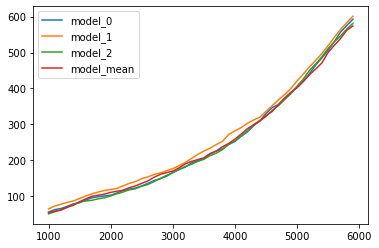

In [ ]:
for i,k in enumerate(dfs):
    r  = make_roc(dfs[k],'prob', n_max=6000, ascending=False)
    plt.plot(r[0],r[1], label=k)
plt.legend()

In [ ]:
keys = ['x_sig','y_sig','z_sig','prob']
pred_df = dfs['model_1']

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

X = np.concatenate([pred_df[keys].values])
y = np.concatenate([pred_df['class'].values])
 
clf = LogisticRegressionCV(random_state=1,max_iter=10000, class_weight='balanced').fit(X, np.array(y, dtype='int'))

In [ ]:
X = np.concatenate([pred_df[keys].values])
pred_df['score'] = clf.predict_proba(X)[:,1]
pred_df['gene'] = targets[pred_df['code_inds']]

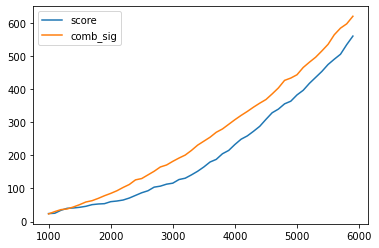

In [ ]:
for df in [pred_df]:
    r  = make_roc(df, 'score', n_max=6000, ascending=True)
    plt.plot(r[0],r[1], label='score')
    r  = make_roc(df, 'comb_sig', n_max=6000, ascending=True)
    plt.plot(r[0],r[1], label='comb_sig')
plt.legend()

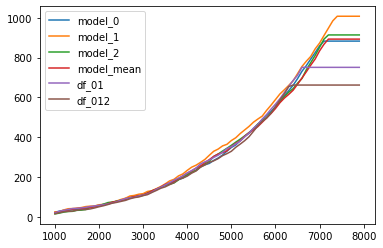

In [ ]:
for i,k in enumerate(dfs):
    pred_df = dfs[k]
    X = np.concatenate([pred_df[keys].values])
    pred_df['score'] = clf.predict_proba(X)[:,1]
    r  = make_roc(dfs[k],'score', n_max=8000, ascending=True)
    plt.plot(r[0],r[1], label=k)
plt.legend()